# Using Real Spectral Fits, Generate Host + [sncosmo](https://sncosmo.readthedocs.io) CCSN Models

In [56]:
from sncosmo.models import Model

from desisim.scripts.quickspectra import sim_spectra
from desispec.io import read_spectra
from desispec.coaddition import coadd_cameras
from desispec.resolution import Resolution
from desispec.interpolation import resample_flux

from speclite import filters
rfilt = filters.load_filters('decam2014-r')

import redrock.templates

from astropy import units as u
from astropy.table import Table, vstack, join

import os
from glob import glob

from scipy.ndimage import gaussian_filter

import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

In [57]:
mpl.rc('font', size=14)

## Access Conditions Data

### Conditions Database Produced by Aaron Meisner

In [58]:
matched_cond_files = sorted(glob('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_*fits'))
obsconditions = Table.read(matched_cond_files[-1], 3)

### Exposure Tables for Our Chosen Spectroscopic Reduction

In [59]:
prefix = os.environ['DESI_SPECTRO_REDUX']
redux = 'everest'
exptab_redux = None

# Loop through all exposure tables corresponding to the chosen pipeline reduction (denali, everest, fuji, ...)
exposure_tables = sorted(glob('{}/{}/exposure_tables/2*/*.csv'.format(prefix, redux)))
columns = ['EXPID', 'EXPTIME', 'OBSTYPE', 'TILEID', 'FA_SURV', 'PROGRAM', 'TARGTRA', 'TARGTDEC', 'NIGHT']

for i, exposure_table in enumerate(exposure_tables):
    exptab = Table.read(exposure_table, format='csv')[columns]
    
    # Remove rows where FA_SURV and PROGRAM are masked.
    select = np.ones(len(exptab), dtype=bool)
    if hasattr(exptab['PROGRAM'], 'mask'):
        select = select & ~exptab['PROGRAM'].mask
    if hasattr(exptab['FA_SURV'], 'mask'):
        select = select & ~exptab['FA_SURV'].mask
    exptab = exptab[select]
    
    if np.any(select):
        select = exptab['PROGRAM'] == 'bright'
        exptab = exptab[select]
        
        if exptab_redux is None:
            exptab_redux = exptab
        else:
            exptab_redux = vstack([exptab_redux, exptab])

#### Join Redux Exposure Table and Obs Conditions Table

In [60]:
obscolumns = ['EXPID', 'SKYRA', 'SKYDEC', 'MOON_ILLUMINATION', 'MOON_ZD_DEG', 'MOON_SEP_DEG',
              'MJD', 'FWHM_ASEC', 'TRANSPARENCY', 'SKY_MAG_AB',
              'FIBER_FRACFLUX', 'FIBER_FRACFLUX_ELG', 'FIBER_FRACFLUX_BGS',
              'AIRMASS', 'RADPROF_FWHM_ASEC',
              'FIBERFAC', 'FIBERFAC_ELG', 'FIBERFAC_BGS']

expobstab = join(exptab_redux, obsconditions[obscolumns], keys=['EXPID'])
expobstab

EXPID,EXPTIME,OBSTYPE,TILEID,FA_SURV,PROGRAM,TARGTRA,TARGTDEC,NIGHT,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,MJD,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS,AIRMASS,RADPROF_FWHM_ASEC,FIBERFAC,FIBERFAC_ELG,FIBERFAC_BGS
int64,float64,str7,int64,str7,str85,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
81839,656.9011,science,81056,sv2,bright,171.412642,50.92891,20210324,171.412642,50.92891,0.8375508202612056,14.927902410006718,37.780937931511055,59298.22121791687,0.978621148692607,1.0049289745540513,19.085540380575374,0.6336533767028059,0.4514740647587236,0.20586830587955238,1.0965814645396126,1.0084405415085644,1.0384483396917168,1.0146258767949523,1.004522271199225
81840,656.9165,science,81056,sv2,bright,171.411559,50.928991,20210324,171.411559,50.928991,0.8383349693445922,16.972920563506136,37.74445843714781,59298.231030149705,1.0346548210201405,1.0189454212684772,19.051809945050618,0.5902722682221583,0.4240048133253208,0.19438778422471725,1.0839774965594144,1.0760511184316415,0.9858504322416539,0.9731871290591765,0.9730188456914106
81841,668.2695,science,81057,sv2,bright,171.526142,54.26575,20210324,171.526142,54.26575,0.8391472041617136,19.372941725560878,39.972400722462254,59298.24120857374,1.137980946923332,1.0685299098219727,19.104750271672415,0.5218730364755861,0.38149811523500776,0.17676541742987822,1.096782718125609,1.1513886184316415,0.960126564750019,0.9565651841473934,0.9578457657788488
81846,668.8473,science,81059,sv2,bright,176.211771,52.438441,20210324,176.211771,52.438441,0.8420134268626445,29.065509299493325,40.90691533133314,59298.2772670527,1.3464095227130972,0.9855880618414308,19.18687015747789,0.4357776164014128,0.3284433420914211,0.15509263023731024,1.069719255008562,1.3237955895854876,0.738754262998055,0.7593640802025132,0.7780499197093167
81847,668.8599,science,81059,sv2,bright,176.210871,52.438461,20210324,176.210871,52.438461,0.8428079101894296,31.924591749720616,40.86715707165989,59298.28730080553,1.0267740019886364,0.9912940633492227,19.2009776279938,0.607291339435732,0.4347493908021789,0.19904275936207044,1.06761326564668,1.062529003047026,0.9956021817274336,0.9764292475826895,0.9714238536591118
81848,702.8672,science,81058,sv2,bright,176.727142,55.763201,20210324,176.727142,55.763201,0.8436328388119623,34.941324702398354,43.110115530253154,59298.29773734984,1.0114104216629607,1.039295052638415,19.204882343485306,0.5881395781409264,0.42132171136166496,0.1931202355059821,1.0932285742109584,1.0591484742008723,1.0441453042079498,1.0238650826717959,1.0167358666746806
81849,702.8606,science,81058,sv2,bright,176.726079,55.76319,20210324,176.726079,55.76319,0.844424707125993,37.872054763286,43.08176874438004,59298.30777340765,1.0834872546557013,1.0442837633744033,19.163232601232878,0.5529438235126478,0.40092886634836694,0.18485794372625064,1.0955244521719516,1.1108222722777952,0.9667346695969463,0.9569624370270033,0.9557450812189107
81850,822.2458,science,81061,sv2,bright,182.3016,57.038491,20210324,182.3016,57.038491,0.8452967911033753,41.13000719724015,46.36697739704693,59298.318846068054,1.2727617533364994,1.024849062009493,19.194821589301462,0.45990100366837927,0.3431017563624116,0.1609820984443179,1.1053361453113861,1.25425328189318,0.7694550608358197,0.7821241412504704,0.7999892104479976
81854,822.2468,science,81061,sv2,bright,182.297558,57.03838,20210324,182.297558,57.03838,0.8482693990040607,52.34269926831075,46.25016454381284,59298.35675058816,1.1168018278217835,0.996670795405667,18.945635449882133,0.5384239405665391,0.39131202847569657,0.18081441503717782,1.13090902901403,1.11613453189318,0.8669765334947328,0.8682447919867684,0.8735026557400596


In [62]:
# List the exposures by survey.
np.unique(expobstab['FA_SURV'], return_counts=True)

(<MaskedColumn name='FA_SURV' dtype='str7' length=4>
 main
  sv1
  sv2
  sv3,
 array([433,   1,  44, 260]))

In [63]:
# List all SV2 tiles + exposures.
sv2 = expobstab['FA_SURV'] == 'sv2'
expobstab[sv2]

EXPID,EXPTIME,OBSTYPE,TILEID,FA_SURV,PROGRAM,TARGTRA,TARGTDEC,NIGHT,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,MJD,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS,AIRMASS,RADPROF_FWHM_ASEC,FIBERFAC,FIBERFAC_ELG,FIBERFAC_BGS
int64,float64,str7,int64,str7,str85,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
81839,656.9011,science,81056,sv2,bright,171.412642,50.92891,20210324,171.412642,50.92891,0.8375508202612056,14.927902410006718,37.780937931511055,59298.22121791687,0.978621148692607,1.0049289745540513,19.085540380575374,0.6336533767028059,0.4514740647587236,0.20586830587955238,1.0965814645396126,1.0084405415085644,1.0384483396917168,1.0146258767949523,1.004522271199225
81840,656.9165,science,81056,sv2,bright,171.411559,50.928991,20210324,171.411559,50.928991,0.8383349693445922,16.972920563506136,37.74445843714781,59298.231030149705,1.0346548210201405,1.0189454212684772,19.051809945050618,0.5902722682221583,0.4240048133253208,0.19438778422471725,1.0839774965594144,1.0760511184316415,0.9858504322416539,0.9731871290591765,0.9730188456914106
81841,668.2695,science,81057,sv2,bright,171.526142,54.26575,20210324,171.526142,54.26575,0.8391472041617136,19.372941725560878,39.972400722462254,59298.24120857374,1.137980946923332,1.0685299098219727,19.104750271672415,0.5218730364755861,0.38149811523500776,0.17676541742987822,1.096782718125609,1.1513886184316415,0.960126564750019,0.9565651841473934,0.9578457657788488
81846,668.8473,science,81059,sv2,bright,176.211771,52.438441,20210324,176.211771,52.438441,0.8420134268626445,29.065509299493325,40.90691533133314,59298.2772670527,1.3464095227130972,0.9855880618414308,19.18687015747789,0.4357776164014128,0.3284433420914211,0.15509263023731024,1.069719255008562,1.3237955895854876,0.738754262998055,0.7593640802025132,0.7780499197093167
81847,668.8599,science,81059,sv2,bright,176.210871,52.438461,20210324,176.210871,52.438461,0.8428079101894296,31.924591749720616,40.86715707165989,59298.28730080553,1.0267740019886364,0.9912940633492227,19.2009776279938,0.607291339435732,0.4347493908021789,0.19904275936207044,1.06761326564668,1.062529003047026,0.9956021817274336,0.9764292475826895,0.9714238536591118
81848,702.8672,science,81058,sv2,bright,176.727142,55.763201,20210324,176.727142,55.763201,0.8436328388119623,34.941324702398354,43.110115530253154,59298.29773734984,1.0114104216629607,1.039295052638415,19.204882343485306,0.5881395781409264,0.42132171136166496,0.1931202355059821,1.0932285742109584,1.0591484742008723,1.0441453042079498,1.0238650826717959,1.0167358666746806
81849,702.8606,science,81058,sv2,bright,176.726079,55.76319,20210324,176.726079,55.76319,0.844424707125993,37.872054763286,43.08176874438004,59298.30777340765,1.0834872546557013,1.0442837633744033,19.163232601232878,0.5529438235126478,0.40092886634836694,0.18485794372625064,1.0955244521719516,1.1108222722777952,0.9667346695969463,0.9569624370270033,0.9557450812189107
81850,822.2458,science,81061,sv2,bright,182.3016,57.038491,20210324,182.3016,57.038491,0.8452967911033753,41.13000719724015,46.36697739704693,59298.318846068054,1.2727617533364994,1.024849062009493,19.194821589301462,0.45990100366837927,0.3431017563624116,0.1609820984443179,1.1053361453113861,1.25425328189318,0.7694550608358197,0.7821241412504704,0.7999892104479976
81854,822.2468,science,81061,sv2,bright,182.297558,57.03838,20210324,182.297558,57.03838,0.8482693990040607,52.34269926831075,46.25016454381284,59298.35675058816,1.1168018278217835,0.996670795405667,18.945635449882133,0.5384239405665391,0.39131202847569657,0.18081441503717782,1.13090902901403,1.11613453189318,0.8669765334947328,0.8682447919867684,0.8735026557400596


## Set up Redrock Templates

Set up templates for generating model fluxes.

In [64]:
templates = dict()
for f in redrock.templates.find_templates():
    t = redrock.templates.Template(f)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## Grab SV2 Tiles and view Redshift/Fibermap tables

In [65]:
sv2_tiles = np.unique(expobstab[sv2]['TILEID'])
tileid = sv2_tiles[0]

expobstab[expobstab['TILEID'] == tileid]['FIBER_FRACFLUX']

0.6336533767028059
0.5902722682221583


In [66]:
len(sv2_tiles)

18

In [67]:
sv2_tiles = np.unique(expobstab[sv2]['TILEID'])
tileid = sv2_tiles[0]

# Get redshift data.
rrtilefolder = sorted(glob('{}/{}/tiles/cumulative/{}/*'.format(prefix, redux, tileid)))[-1]
rrfiles = sorted(glob('{}/redrock*.fits'.format(rrtilefolder)))
redshifts = None
fibermaps = None

for rrfile in rrfiles:
    redshift = Table.read(rrfile, 'REDSHIFTS')
    fibermap = Table.read(rrfile, 'FIBERMAP')
    
    # Select galaxy targets with good redshifts.
    select = (redshift['ZWARN']==0) & (redshift['DELTACHI2']>=25) & (redshift['SPECTYPE']=='GALAXY')
    redshift = redshift[select]
    
    i = np.in1d(fibermap['TARGETID'], redshift['TARGETID'])
    fibermap = fibermap[i]
    
    if redshifts is None:
        redshifts = redshift
        fibermaps = fibermap
    else:
        redshifts = vstack([redshifts, redshift])
        fibermaps = vstack([fibermaps, fibermap])
        
redshifts

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64
39633244055930066,9420.912271149457,-325.3402127034103 .. -14.090545499869723,0.29927018531930694,4.037465254096842e-05,0,7919,GALAXY,,10,37.68648897856474
39633244055931465,8759.610308978707,-133.84292724119211 .. 14.332934474773003,0.29105402417923687,5.761142657534843e-05,0,7918,GALAXY,,10,185.02364775165915
39633247969217075,9165.178549259901,-275.3576519881777 .. -38.839354087666656,0.29006983454452023,1.77276507424914e-05,0,7922,GALAXY,,10,358.1266112625599
39633247973409609,8851.310881853104,238.30427153696698 .. 2.8536951886409696,0.3361080839611094,9.084562705033209e-06,0,7924,GALAXY,,10,2492.513094186783
39633247969214833,8776.083568513393,-6.232930774957366 .. -9.382669854847979,0.2949754072238761,1.7760809900591825e-05,0,7924,GALAXY,,10,285.18860203027725
39633244060124915,8752.992849051952,884.374431090617 .. 0.9553714973717417,0.19125497026549856,2.0346023814548418e-05,0,7923,GALAXY,,10,207.52731642872095
39633247969216454,9549.015422426164,343.76816983401324 .. 67.79858108759768,0.19886572404207126,5.1762777067039814e-05,0,7924,GALAXY,,10,2376.092539526522
39633244055930846,9454.587720155716,1297.6081104979246 .. 30.611917478926994,0.19936889270670174,7.816844182544409e-06,0,7926,GALAXY,,10,923.2150750160217
39633244060125069,9109.65688174963,1089.7142612889322 .. 55.90521264706627,0.19867109964120214,1.0917115342170794e-05,0,7923,GALAXY,,10,755.3465057015419


In [68]:
fibermaps

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39633244055930066,0,311,311,0,0,170.8699857500975,49.76892754978972,0.0,0.0,2015.5,5400.0,1152921504606847233,1,TGT,86.48459,-287.65414,2100,0.9395785347629364,517,9011,583397,1234,SER,6.7733765,26.101282,61.48094,88.65161,20.110308,7.3127165,0,0,,0.0,0.0,0.0,0.0,1709p497,0.014552638,94.740906,69.563866,1.3918839,0.45568678,1.5955441,6.1484475,14.48252,1.5955441,6.1484475,14.48252,6.0,2.8254607,-0.2689399,-0.14559409,N,2100,1,1152921504606847233,514,0,0,0,0,0,170.8699857500975,49.76892754978972,81056,2,1313.8176,1,1,0.0005,0.0015811388,-0.0035,0.008276473,170.86998841951865,0.05697174,49.768941031821846,0.10417267,0.7334719,86.463,-287.633
39633244055931465,0,272,272,1,0,171.04050860064976,49.81567766823149,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,58.839222,-275.4177,2100,0.07787522391859647,519,9011,583397,2633,SER,3.3565753,11.44471,25.897852,223.83655,58.630627,27.196022,0,0,,0.0,0.0,0.0,0.0,1709p497,0.013047796,42.421795,29.396263,2.685968,0.7934125,1.2381867,4.22177,9.553301,1.2386556,4.223061,9.554749,2.436738,1.2132702,-0.510567,-0.07645793,N,2100,1,1152921504606846976,265,0,0,0,0,0,171.04050860064976,49.81567766823149,81056,2,1313.8176,1,1,-0.001,0.0031622776,-0.001,0.008062257,171.04050228303038,0.10805533,49.815681557626405,0.111827195,0.74759036,58.82,-275.402
39633247969217075,0,156,156,3,0,171.3726564024677,50.02008653112292,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,5.5479584,-223.10687,2100,0.7779726891458255,519,9011,584330,2611,EXP,3.2703528,10.009163,22.41547,216.66922,56.65909,21.803429,0,0,,0.0,0.0,0.0,0.0,1712p500,0.012646031,48.417866,46.67838,2.5163128,0.72558516,0.96541643,2.95473,6.6171036,0.96541643,2.9547303,6.6171045,1.0,1.5573188,0.12452993,0.56345135,N,2100,1,1152921504606846976,265,0,0,0,0,0,171.3726564024677,50.02008653112292,81056,2,1313.8176,1,1,0.0005,0.0015811388,-0.0055,0.01097725,171.37265950745262,0.053619917,50.02010831773731,0.13545993,0.7440748,5.5325,-223.0945
39633247973409609,0,198,198,4,0,171.56385095759393,49.906037354381255,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,-24.847942,-252.14806,2000,0.5895385918210945,519,9011,584331,841,SER,5.5453744,12.1173525,20.436043,238.69131,66.91228,53.33941,0,0,,0.0,0.0,0.0,0.0,1716p500,0.011544353,24.202469,21.674526,3.2864256,0.88049877,2.067241,4.517186,7.618282,2.067241,4.517186,7.618282,0.656211,1.0204703,-0.34977415,0.022133052,N,2000,1,1152921504606846976,257,0,0,0,0,0,171.56385095759393,49.906037354381255,81056,2,1313.8176,

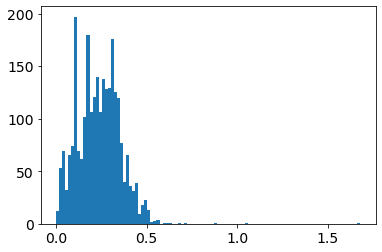

In [69]:
#View distribution of redshifts
r = 22.5 - 2.5*np.log10(fibermaps['FLUX_R'])
plt.hist(redshifts['Z'], bins=100);

### Extract ~50,000 Model Fluxes which will serve as hosts

In [136]:
# Host fluxes and FLUX_R saved in dictionary with redshifts as keys.
hosts=dict()
sv2_tiles = np.unique(expobstab[sv2]['TILEID'])
n=1900
    
for i in range (len(sv2_tiles)):

    tileid = sv2_tiles[i]

    # Get redshift data.
    rrtilefolder = sorted(glob('{}/{}/tiles/cumulative/{}/*'.format(prefix, redux, tileid)))[-1]
    rrfiles = sorted(glob('{}/redrock*.fits'.format(rrtilefolder)))
    redshifts = None
    fibermaps = None

    for rrfile in rrfiles:
        redshift = Table.read(rrfile, 'REDSHIFTS')
        fibermap = Table.read(rrfile, 'FIBERMAP')

        # Select galaxy targets with good redshifts.
        select = (redshift['ZWARN']==0) & (redshift['DELTACHI2']>=25) & (redshift['SPECTYPE']=='GALAXY')
        redshift = redshift[select]

        j = np.in1d(fibermap['TARGETID'], redshift['TARGETID'])
        fibermap = fibermap[j]

        if redshifts is None:
            redshifts = redshift
            fibermaps = fibermap
        else:
            redshifts = vstack([redshifts, redshift])
            fibermaps = vstack([fibermaps, fibermap])
        
    for r in range(n):
            wave = np.arange(3300., 11000)

    
            targetid, z, sp, sb, coeff = redshifts[r][['TARGETID', 'Z', 'SPECTYPE', 'SUBTYPE', 'COEFF']]

            fmap_select = fibermaps['TARGETID'] == targetid
            row = fibermaps[['FLUX_R', 'FIBERFLUX_R']][fmap_select]
            flux_r, fiberflux_r = [row[_] for _ in ['FLUX_R', 'FIBERFLUX_R']]
            r_gal = 22.5 - 2.5*np.log10(flux_r)
            
            #if z<0.0:
               # pass
                
            #else:

            ncoeff = templates[(sp, sb)].flux.shape[0]
            coeff = coeff[0:ncoeff]


            tflux = templates[(sp, sb)].flux.T.dot(coeff)
            twave = templates[(sp, sb)].wave * (1 + z)


            txflux = resample_flux(wave, twave, tflux, ivar=None, extrapolate=False)
            key=str(z)
            items=(txflux,flux_r)
            hosts[key]=items



           

len(hosts)

34200

## Random visual check of Hosts

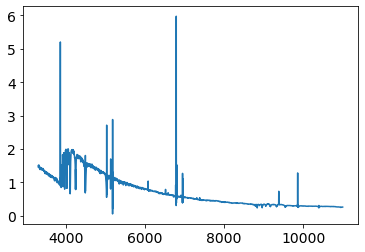

In [137]:
keys=list(hosts.keys())
i = random.choice(keys)
plt.plot(wave, hosts[i][0])

### Read models from Vincenzi file

In [138]:
# Import models from Vincenzo et al.
modtab = Table.read('vincenzi_2019_models.fits')


#Remove the models deemed faulty from visual inspection
faulty = ['SN2013by','SN2013fs','SN2009bw','SN2012aw','SN2009kr','ASASSN14jb','SN2013am','SN2008ax','SN2008fq','SN2009ip','IPTF13bvn','SN2008D','SN1994I',
'SN2007gr','SN2009bb','SN2007ru']
select = [x not in faulty for x in modtab['Name']]

# Black list some of the models. Create the key needed to set up sncosmo.
models = modtab[select]
models

Name,Type,Redshift,Peak MB,Optical data,Near-UV data,Nspectra,EBV
bytes10,bytes8,float64,float64,bytes13,bytes20,int64,float64
ASASSN15oz,II,0.00693,-18.19,UBVRIgri,"u,b,v,uvw1,uvm2,uvw2",13,0.0
SN2014G,II,0.00563,-18.1,UBVRI,"v,uvw1,uvm2,uvw2",17,0.24
SN2007od,II,0.00586,-17.93,UBVRIri,"u,b,v,uvw1,uvm2,uvw2",13,0.0
SN2013ej,II,0.00219,-17.76,UBVRIgriz,"u,b,v,uvw1,uvm2,uvw2",28,0.049
SN2008bj,II,0.019,-17.48,UBVri,,16,0.081
SN2016X,II,0.00441,-17.38,UBVRIgri,"u,b,v,uvw1,uvm2,uvw2",33,0.02
SN2013ab,II,0.00532,-17.14,BVRIgri,"u,b,uvw1,uvm2,uvw2",22,0.02
SN2004et,II,0.00105,-17.09,UBVRI,,28,0.07
SN2008in,II,0.00522,-16.96,BVri,"u,b,v,uvw1,uvm2,uvw2",10,0.076


#### Generating hosts takes some time, use copies for easier manipulation

In [139]:
hosts2=hosts.copy()
keys2=keys.copy()

In [140]:
def calc_flux(z, t, model, obswave, return_range=False):
    """Compute flux from an sncosmo model given redshift and time.
    
    Parameters
    ----------
    z : float
        Source redshift.
    t : float
        Source phase / epoch (usually time to max light in days).
    model : sncosmo.models.Model
        Model with builtin flux.
    obswave : ndarray
        Input array of observed wavelengths.
    return_range : bool
        If true, return model min and max wavelength.
    
    Returns
    -------
    flux : ndarray
        Model flux calculated vs obswave.
    minwave : float (optional)
        Minimum wavelength of model given redshift z.
    maxwave : float (optional)
        Maximum wavelength of model given redshift z.
    """
    model.set(z=z)
    select = (obswave >= model.minwave()) & (obswave <= model.maxwave())
    flux = np.zeros_like(obswave)
    flux[select] = model.flux(t, obswave[select])
    if return_range:
        return flux, model.minwave(), model.maxwave()
    return flux

### Function used to generate SN fluxes

In [141]:
def generate_ccsn(models,sel,hosts):
    
    """ Function that generates CCSN fluxes added to hosts
    
    Parameters
    ----------
    
    models : list/Table
        list with different SN models to be generated
        
    sel    :  Array 
        Boolean array used to distinguish SN type
    
    hosts  : Dictionary
        Dictionary with redshifts as keys and a tuple as the items.
        first entry of tuple corresponds to an array of flux values
        second entry is the Flux_R drawn from fibermaps
    
    Returns
    ----------
    ccsnfluxes : Array
        Array of SN fluxes
        
    ccsn_host   : Array
        Array of SN fluxes added to host fluxes
    
    
    """
    
    ccsnfluxes=[]
    ccsn_host=[]
    
    
    for model in models[sel]:
    
        
            for i in range (1200):

                redshift = random.choice(keys2)
                host_flux = hosts2[redshift][0]
                flux_r=hosts2[redshift][1]
                r_gal = 22.5 - 2.5*np.log10(flux_r)

                nm = model['Name']
                tp = model['Type']

                if nm.startswith('SN'):
                        model_name= 'v19-{}-corr'.format(nm[2:].lower())
                        ccsn = Model(model_name)

                else:
                  model_name = 'v19-{}-corr'.format(nm.lower())
                  ccsn= Model(model_name)

                wmin = np.maximum(3300., ccsn.minwave())
                wmax = np.minimum(11000., ccsn.maxwave())
                wave = np.arange(wmin, wmax)


                # Set redshift and apparent magnitude in the r-band, using SDSS filter.
                
                #Different phases of SN 14 days prior and after maximum light
                tmin = np.maximum(np.round(ccsn.mintime(), 0), -14)
                tmax = np.minimum(np.round(ccsn.maxtime(), 0), 28)
                times = np.round(np.linspace(tmin, tmax, 21), 0)
                t = np.random.choice(times, size=1, replace=False)
                
            
                z= float(redshift)
                ccsnflux = calc_flux(z, t=t, model=ccsn, obswave=wave) * 1e17 * 0.6
                
                magnitudes=np.round(np.linspace(0,5, 16), 0)
                delta_r = np.random.choice(magnitudes, size=1, replace=False)
                rfluxratio = 10**(-delta_r/2.5)

                
                #print(t,nm,z)

                ccsn.set_source_peakmag(r_gal, band='desr', magsys='vega')

                galnorm = rfilt.get_ab_maggies(txflux, wave)
                fluxr_gal = galnorm['decam2014-r'].data


                ccsnorm = rfilt.get_ab_maggies(ccsnflux, wave)
                fluxr_ccsn = ccsnorm['decam2014-r'].data


                ccsnfactor = fluxr_gal * rfluxratio / fluxr_ccsn


                ccsnflux = ccsnfactor * ccsnflux
                ccsnfluxes.append(ccsnflux)

                totflux = host_flux + ccsnflux
                ccsn_host.append(totflux)

                del hosts2[redshift]
                keys2.remove(redshift)
            
        
    return ccsnfluxes,ccsn_host

## Instantiate CCSN Models from Vincenzi

In [142]:
II= models['Type'] == 'II'
IIb= models['Type'] == 'IIb'
IIn= models['Type'] == 'IIn'

Ib= models['Type'] == 'Ib'
Ic= models['Type'] == 'Ic'
Ic_BL= models['Type'] == 'Ic-BL'

    
ii_flux,ii_host = generate_ccsn(models,II,hosts2)
iib_flux,iib_host = generate_ccsn(models,IIb,hosts2)
iin_flux,iin_host = generate_ccsn(models,IIn,hosts2)
ib_flux,ib_host = generate_ccsn(models,Ib,hosts2)
ic_flux,ic_host = generate_ccsn(models,Ic,hosts2)
icBL_flux,icBL_host = generate_ccsn(models,Ic_BL,hosts)


len(ii_host),len(iib_host),len(iin_host),len(ib_host),len(ic_host),len(icBL_host)

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [113]:
len(hosts2),len(keys2)

(0, 0)

### Instantiate Type Ia SNe models from hsiao models

In [ ]:
source = sncosmo.get_source('hsiao', version='2.0')
ccsn = sncosmo.Model(source=source)
ia_fluxes=[]
ia_host=[]
n=6000

for i in range (n):
    
        redshift = random.choice(keys2)
        host_flux = hosts2[redshift][0]
        flux_r=hosts[redshift][1]
        r_gal = 22.5 - 2.5*np.log10(flux_r)
         
       # Set redshift and apparent magnitude in the r-band, using SDSS filter.
       z= float(redshift)
       ccsn.set(z=z)
       magnitudes=np.round(np.linspace(0,5, 16), 0)
       delta_r = np.random.choice(magnitudes, size=1, replace=False)
       rfluxratio = 10**(-delta_r/2.5)
            
       #Different phases of SN 14 days prior and after maximum light
       tmin = np.maximum(np.round(ccsn.mintime(), 0), -10)
       tmax = np.minimum(np.round(ccsn.maxtime(), 0), 28)
       times = np.round(np.linspace(tmin, tmax, 16), 0)
       t = np.random.choice(times, size=1, replace=False)

       ccsn.set_source_peakmag(r_gal, band='desr', magsys='vega')
       ccsnflux = ccsn.flux(t, wave) * 1e17 * 0.6 # dummy fiber fraction

       galnorm = rfilt.get_ab_maggies(txflux, wave)
       fluxr_gal = galnorm['decam2014-r'].data
            

        ccsnorm = rfilt.get_ab_maggies(ccsnflux, wave)
        fluxr_ccsn = ccsnorm['decam2014-r'].data
            

        ccsnfactor = fluxr_gal * rfluxratio / fluxr_ccsn

            
        ccsnflux = ccsnfactor * ccsnflux
        ia_fluxes.append(ccsnflux)
            
        totflux = host_flux + ccsnflux
        ia_host.append(totflux)
           
    
        

### Plot the Redrock Model + Our CCSN Flux

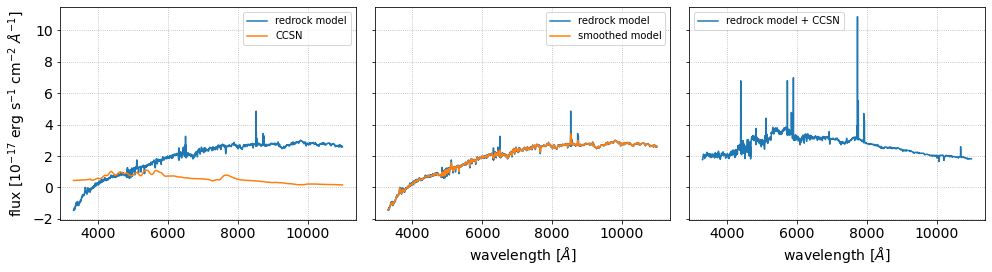

In [102]:
fig, axes = plt.subplots(1,3, figsize=(14,4), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.plot(wave, hosts['0.29927018531930694'][0], label='redrock model')
ax.plot(wave, ii_flux[0][0], label='CCSN')
ax.set(ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.legend(fontsize=10)
ax.grid(ls=':')

ax = axes[1]
ax.plot(wave, hosts['0.29927018531930694'][0], label='redrock model')
ax.plot(wave, gaussian_filter(hosts['0.29927018531930694'][0], 5), label='smoothed model')
ax.set(xlabel=r'wavelength [$\AA$]')
ax.legend(fontsize=10)
ax.grid(ls=':');

ax = axes[2]
ax.plot(wave, ii_host[0][0], label='redrock model + CCSN')
ax.set(xlabel=r'wavelength [$\AA$]')
ax.legend(fontsize=10)
ax.grid(ls=':')

## Simulate the CCSN Model

In [76]:
# Get observing conditions.

def simulate_model(fluxes,expo):
    
    specdata = None
    for flux in fluxes:
        
        tiles=np.round(np.linspace(0,18,1), 0)
        i=np.random.choice(tiles, size=1, replace=False)
        tileid = sv2_tiles[i]
        
        conditions=np.round(np.linspace(0,26,1), 0)
        j=np.random.choice(conditions, size=1, replace=False)
        
        exposure_data = expobstab[expobstab['TILEID'] == tileid][j]
        obsconditions = {
        'SEEING'   : exposure_data['FWHM_ASEC'],
        'EXPTIME'  : exposure_data['EXPTIME'],
        'AIRMASS'  : exposure_data['AIRMASS'],
        'MOONFRAC' : exposure_data['MOON_ILLUMINATION'],
        'MOONALT'  : exposure_data['MOON_ZD_DEG'],
        'MOONSEP'  : exposure_data['MOON_SEP_DEG']
                    }

        spectra= sim_spectra(wave,flux, program='bright',
                #spectra_filename='test_{}.fits'.format(ccsn.source.name),
                obsconditions=obsconditions,
                sourcetype='bgs'
               )
        
        spectra=coadd_cameras(spectra)
        
        if specdata is None :
            specdata = spectra
        else :
            specdata.update(spectra)
            
    return specdata

{'SEEING': 1.0346548210201405,
 'EXPTIME': 656.9165,
 'AIRMASS': 1.0839774965594144,
 'MOONFRAC': 0.8383349693445922,
 'MOONALT': 16.972920563506136,
 'MOONSEP': 37.74445843714781}

### Read and Plot the Spectra

In [20]:
# spectra = read_spectra('test_v19-2009ip-corr.fits')
spectra = read_spectra('test_v19-2009iz-corr.fits')
coadds = coadd_cameras(spectra)

INFO:spectra.py:282:read_spectra: iotime 0.058 sec to read test_v19-2009iz-corr.fits at 2021-08-17T07:55:31.823482


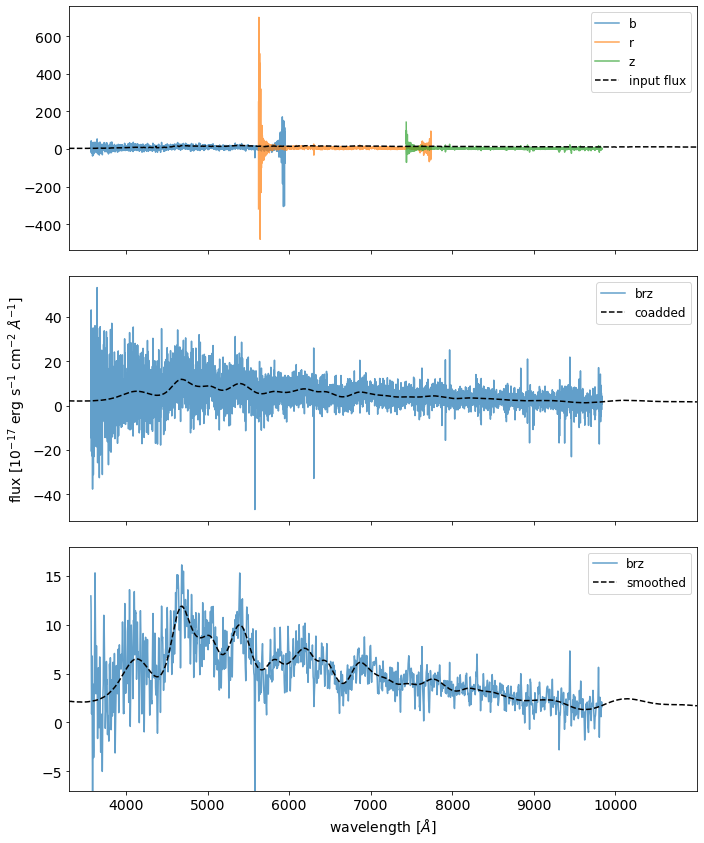

In [21]:
from scipy.ndimage import gaussian_filter

# fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True, sharey=True, tight_layout=True)
fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True, tight_layout=True)

for band in 'brz':
    ax = axes[0]
    ax.plot(spectra.wave[band], spectra.flux[band][0], alpha=0.7, label=band)
    ax.set(xlim=(wave[0], wave[-1]))
ax.plot(wave, totflux, 'k--', label='input flux')
ax.legend(loc='upper right', fontsize=12);
    
ax = axes[1]
ax.plot(coadds.wave['brz'], coadds.flux['brz'][0], alpha=0.7, label='brz')
ax.plot(wave, ccsnflux, 'k--', label='coadded')
ax.set(ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.legend(loc='upper right', fontsize=12)

ax = axes[2]
smoothed = gaussian_filter(coadds.flux['brz'][0], 3)
ax.plot(coadds.wave['brz'], smoothed, alpha=0.7, label='brz')
ax.plot(wave, ccsnflux, 'k--', label='smoothed')
ax.set(xlabel=r'wavelength [$\AA$]',
       ylim=(np.floor(0.9*np.min(smoothed)), np.round(1.1*np.max(smoothed), 0)))
ax.legend(loc='upper right', fontsize=12);

In [22]:
spectra.wave

{'b': array([3569., 3570., 3571., ..., 5947., 5948., 5949.]),
 'r': array([5625., 5626., 5627., ..., 7739., 7740., 7741.]),
 'z': array([7435., 7436., 7437., ..., 9832., 9833., 9834.])}